Name: Shubhajeet Das <br />
Roll No.: 24AI10013 <br />
DL Lab 3

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


# Framework
import torch
import torchvision

# Data and its management related libraries
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image

# For creating neural networks
import torch.nn as nn
import torch.nn.functional as F

# For optimizing neural networks
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# For metrics and analysis
from sklearn.metrics import accuracy_score
from torchsummary import summary

# For dataset loading
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
SEED = 42
def set_all_seeds(seed):
    """
    Sets seeds for NumPy and PyTorch.
    NOTE: scikit-learn requires random_state to be set per estimator.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds(SEED)

## Question 1 (2 marks)

1.   Load the California housing dataset from scikit-learn
2.   Split the dataset into training, validation and test sets (70%-15%-15% split)
3.  Standardize the features.


In [3]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(14448, 8) (3096, 8) (3096, 8)
(14448,) (3096,) (3096,)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


## Question 2 (2 marks)
Construct a feedforward neural network with 2 hidden layers (1st layer -> 64 neurons, 2nd layer -> 32 neurons). Use ReLU activation for the hidden layers, and a suitable activation for the output layer.


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Question 3 (5 marks)

1. Design RMSProp optimizer from scratch.
2. Design following from scratch
     * MSE loss
     * MAE loss
     * RMSE loss
     * R2 score
     * L1 regularization loss
     * L2 regularization loss


In [7]:
class RMSPropScratch:
    def __init__(self, params, lr=0.001, alpha=0.99, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.s = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            grad = p.grad.data
            self.s[i] = self.alpha * self.s[i] + (1 - self.alpha) * grad**2
            p.data -= self.lr * grad / (torch.sqrt(self.s[i]) + self.eps)

def mse_loss_scratch(predictions, targets):
    return ((predictions - targets)**2).mean()

def mae_loss_scratch(predictions, targets):
    return (predictions - targets).abs().mean()

def rmse_loss_scratch(predictions, targets):
    return torch.sqrt(mse_loss_scratch(predictions, targets))

def r2_score_scratch(predictions, targets):
    sum_of_squared_residuals = ((targets - predictions)**2).sum()
    total_sum_of_squares = ((targets - targets.mean())**2).sum()

    if total_sum_of_squares == 0:
        return torch.tensor(0.0)
    return 1 - (sum_of_squared_residuals / total_sum_of_squares)

def l1_regularization_scratch(model, lambda_l1):
    l1_loss = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_loss = l1_loss + torch.abs(param).sum()
    return lambda_l1 * l1_loss

def l2_regularization_scratch(model, lambda_l2):
    l2_loss = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_loss = l2_loss + torch.norm(param, 2)**2
    return lambda_l2 * l2_loss

print("Scratch implementations for RMSProp, MSE, MAE, RMSE, R2, L1, and L2 are defined.")

Scratch implementations for RMSProp, MSE, MAE, RMSE, R2, L1, and L2 are defined.



## Question 4 (5 marks)
1. Train the model using RMSProp (scratch) optimizer with suitable learning rate and batchsize.
2. Try following combinations of loss functions (scratch) with appropriate tradeoff hyperparameters:
     * MSE + L2
     * RMSE + L1
     * MSE + L1+L2
3. Show the variation of the training and validation losses with each training progress.
4. Report the loss on validation set and test set


In [8]:
batch_size = 32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data converted to PyTorch tensors and DataLoaders created.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Data converted to PyTorch tensors and DataLoaders created.
Number of training batches: 452
Number of validation batches: 97
Number of test batches: 97


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
input_size = X_train_scaled.shape[1]
model_mse_l2 = NeuralNetwork(input_size).to(device)

lr_rmsprop = 0.001
alpha_rmsprop = 0.99
eps_rmsprop = 1e-8
optimizer_scratch_mse_l2 = RMSPropScratch(model_mse_l2.parameters(), lr=lr_rmsprop, alpha=alpha_rmsprop, eps=eps_rmsprop)

num_epochs = 100

lambda_l2 = 0.001

train_losses_mse_l2 = []
val_losses_mse_l2 = []

print(f"Starting training with custom RMSProp (lr={lr_rmsprop}, alpha={alpha_rmsprop}, eps={eps_rmsprop}) and MSE + L2 (lambda={lambda_l2})...\n")

for epoch in range(num_epochs):
    model_mse_l2.train()
    current_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for p in model_mse_l2.parameters():
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

        predictions = model_mse_l2(data)

        mse_loss = mse_loss_scratch(predictions, target)

        l2_reg = l2_regularization_scratch(model_mse_l2, lambda_l2)

        total_loss = mse_loss + l2_reg
        total_loss.backward()

        optimizer_scratch_mse_l2.step()
        current_train_loss += total_loss.item()

    avg_train_loss = current_train_loss / len(train_loader)
    train_losses_mse_l2.append(avg_train_loss)

    model_mse_l2.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            predictions = model_mse_l2(data)

            mse_loss_val = mse_loss_scratch(predictions, target)
            l2_reg_val = l2_regularization_scratch(model_mse_l2, lambda_l2)
            total_val_loss = mse_loss_val + l2_reg_val
            current_val_loss += total_val_loss.item()

    avg_val_loss = current_val_loss / len(val_loader)
    val_losses_mse_l2.append(avg_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining with custom RMSProp and MSE + L2 complete.")

Using device: cuda
Starting training with custom RMSProp (lr=0.001, alpha=0.99, eps=1e-08) and MSE + L2 (lambda=0.001)...

Epoch [1/100], Train Loss: 0.7546, Val Loss: 0.5144
Epoch [10/100], Train Loss: 0.3724, Val Loss: 0.3960
Epoch [20/100], Train Loss: 0.3498, Val Loss: 0.3663
Epoch [30/100], Train Loss: 0.3430, Val Loss: 0.3890
Epoch [40/100], Train Loss: 0.3369, Val Loss: 0.3595
Epoch [50/100], Train Loss: 0.3316, Val Loss: 0.3553
Epoch [60/100], Train Loss: 0.3282, Val Loss: 0.3505
Epoch [70/100], Train Loss: 0.3273, Val Loss: 0.3562
Epoch [80/100], Train Loss: 0.3252, Val Loss: 0.3932
Epoch [90/100], Train Loss: 0.3237, Val Loss: 0.3499
Epoch [100/100], Train Loss: 0.3213, Val Loss: 0.3547

Training with custom RMSProp and MSE + L2 complete.


In [10]:
model_rmse_l1 = NeuralNetwork(input_size).to(device)

lr_rmsprop = 0.001
alpha_rmsprop = 0.99
eps_rmsprop = 1e-8
optimizer_scratch_rmse_l1 = RMSPropScratch(model_rmse_l1.parameters(), lr=lr_rmsprop, alpha=alpha_rmsprop, eps=eps_rmsprop)

num_epochs = 100

lambda_l1 = 0.001

train_losses_rmse_l1 = []
val_losses_rmse_l1 = []

print(f"Starting training with custom RMSProp (lr={lr_rmsprop}, alpha={alpha_rmsprop}, eps={eps_rmsprop}) and RMSE + L1 (lambda={lambda_l1})...\n")

for epoch in range(num_epochs):
    model_rmse_l1.train()
    current_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for p in model_rmse_l1.parameters():
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

        predictions = model_rmse_l1(data)

        rmse_loss = rmse_loss_scratch(predictions, target)

        l1_reg = l1_regularization_scratch(model_rmse_l1, lambda_l1)

        total_loss = rmse_loss + l1_reg
        total_loss.backward()

        optimizer_scratch_rmse_l1.step()
        current_train_loss += total_loss.item()

    avg_train_loss = current_train_loss / len(train_loader)
    train_losses_rmse_l1.append(avg_train_loss)

    model_rmse_l1.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            predictions = model_rmse_l1(data)

            rmse_loss_val = rmse_loss_scratch(predictions, target)
            l1_reg_val = l1_regularization_scratch(model_rmse_l1, lambda_l1)
            total_val_loss = rmse_loss_val + l1_reg_val
            current_val_loss += total_val_loss.item()

    avg_val_loss = current_val_loss / len(val_loader)
    val_losses_rmse_l1.append(avg_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining with custom RMSProp and RMSE + L1 complete.")

Starting training with custom RMSProp (lr=0.001, alpha=0.99, eps=1e-08) and RMSE + L1 (lambda=0.001)...

Epoch [1/100], Train Loss: 0.9212, Val Loss: 0.8263
Epoch [10/100], Train Loss: 0.6582, Val Loss: 0.6689
Epoch [20/100], Train Loss: 0.6224, Val Loss: 0.6445
Epoch [30/100], Train Loss: 0.6082, Val Loss: 0.6303
Epoch [40/100], Train Loss: 0.5957, Val Loss: 0.6202
Epoch [50/100], Train Loss: 0.5911, Val Loss: 0.6079
Epoch [60/100], Train Loss: 0.5841, Val Loss: 0.6007
Epoch [70/100], Train Loss: 0.5810, Val Loss: 0.5956
Epoch [80/100], Train Loss: 0.5794, Val Loss: 0.5938
Epoch [90/100], Train Loss: 0.5772, Val Loss: 0.5891
Epoch [100/100], Train Loss: 0.5762, Val Loss: 0.5857

Training with custom RMSProp and RMSE + L1 complete.


In [11]:
model_mse_l12 = NeuralNetwork(input_size).to(device)

lr_rmsprop = 0.001
alpha_rmsprop = 0.99
eps_rmsprop = 1e-8
optimizer_scratch_mse_l12 = RMSPropScratch(model_mse_l12.parameters(), lr=lr_rmsprop, alpha=alpha_rmsprop, eps=eps_rmsprop)

num_epochs = 100

lambda_l1 = 0.001
lambda_l2 = 0.001

train_losses_mse_l12 = []
val_losses_mse_l12 = []

print(f"Starting training with custom RMSProp (lr={lr_rmsprop}, alpha={alpha_rmsprop}, eps={eps_rmsprop}) and MSE + L1 + L2 (lambda={lambda_l1}, {lambda_l2})...\n")

for epoch in range(num_epochs):
    model_mse_l12.train()
    current_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for p in model_mse_l12.parameters():
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

        predictions = model_mse_l12(data)

        mse_loss = mse_loss_scratch(predictions, target)

        l1_reg = l1_regularization_scratch(model_mse_l12, lambda_l1)
        l2_reg = l2_regularization_scratch(model_mse_l12, lambda_l2)

        total_loss = mse_loss + l1_reg + l2_reg
        total_loss.backward()

        optimizer_scratch_mse_l12.step()
        current_train_loss += total_loss.item()

    avg_train_loss = current_train_loss / len(train_loader)
    train_losses_mse_l12.append(avg_train_loss)

    model_mse_l12.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            predictions = model_mse_l12(data)

            mse_loss_val = mse_loss_scratch(predictions, target)
            l1_reg_val = l1_regularization_scratch(model_mse_l12, lambda_l1)
            l2_reg_val = l2_regularization_scratch(model_mse_l12, lambda_l2)
            total_val_loss = mse_loss_val + l1_reg_val + l2_reg_val
            current_val_loss += total_val_loss.item()

    avg_val_loss = current_val_loss / len(val_loader)
    val_losses_mse_l12.append(avg_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining with custom RMSProp and MSE + L1 + L2 complete.")

Starting training with custom RMSProp (lr=0.001, alpha=0.99, eps=1e-08) and MSE + L1 + L2 (lambda=0.001, 0.001)...

Epoch [1/100], Train Loss: 0.8391, Val Loss: 0.7518
Epoch [10/100], Train Loss: 0.4584, Val Loss: 0.4694
Epoch [20/100], Train Loss: 0.4161, Val Loss: 0.4512
Epoch [30/100], Train Loss: 0.3996, Val Loss: 0.4135
Epoch [40/100], Train Loss: 0.3910, Val Loss: 0.4183
Epoch [50/100], Train Loss: 0.3863, Val Loss: 0.4117
Epoch [60/100], Train Loss: 0.3829, Val Loss: 0.4037
Epoch [70/100], Train Loss: 0.3814, Val Loss: 0.4066
Epoch [80/100], Train Loss: 0.3778, Val Loss: 0.4167
Epoch [90/100], Train Loss: 0.3770, Val Loss: 0.3947
Epoch [100/100], Train Loss: 0.3753, Val Loss: 0.3986

Training with custom RMSProp and MSE + L1 + L2 complete.


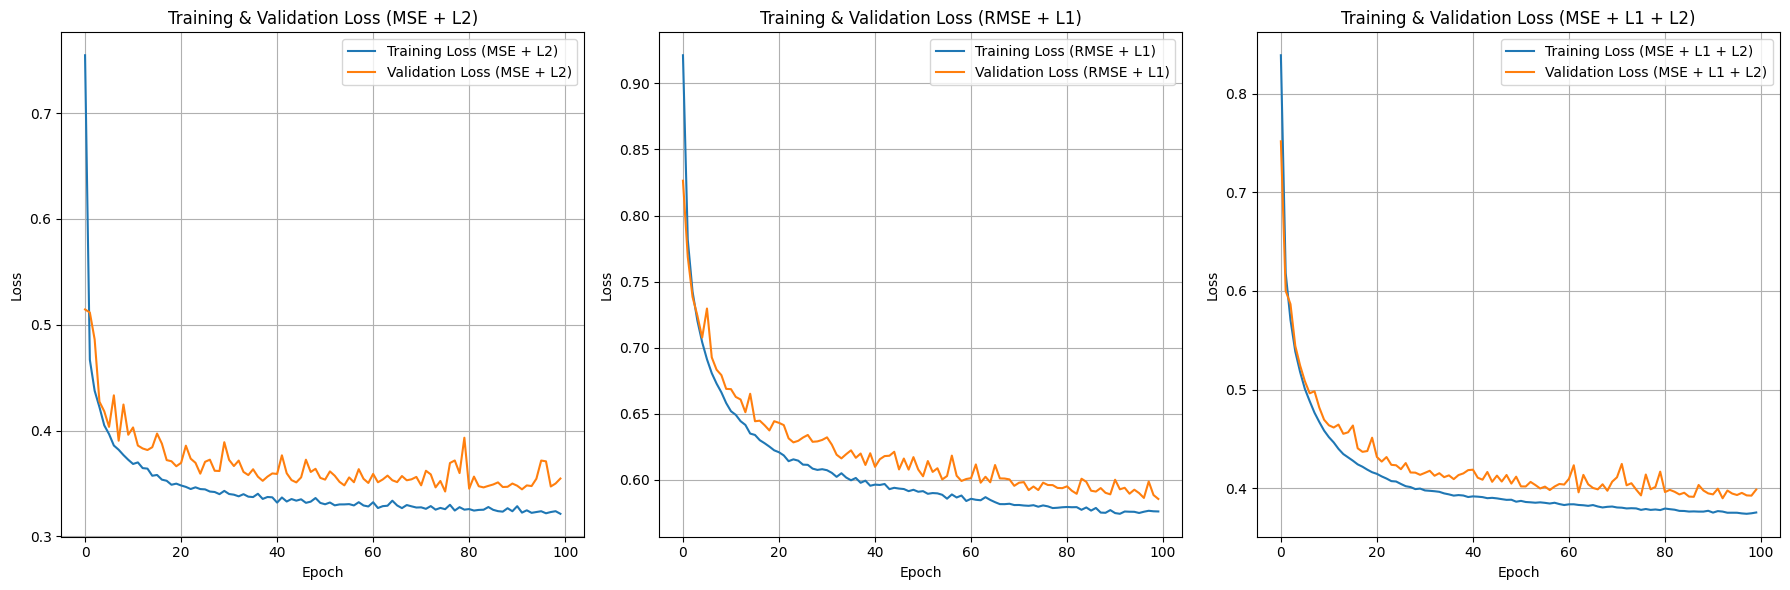

Loss curves for all three scratch models plotted successfully.


In [12]:
plt.figure(figsize=(18, 6))

# Plot for MSE + L2
plt.subplot(1, 3, 1)
plt.plot(train_losses_mse_l2, label='Training Loss (MSE + L2)')
plt.plot(val_losses_mse_l2, label='Validation Loss (MSE + L2)')
plt.title('Training & Validation Loss (MSE + L2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot for RMSE + L1
plt.subplot(1, 3, 2)
plt.plot(train_losses_rmse_l1, label='Training Loss (RMSE + L1)')
plt.plot(val_losses_rmse_l1, label='Validation Loss (RMSE + L1)')
plt.title('Training & Validation Loss (RMSE + L1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot for MSE + L1 + L2
plt.subplot(1, 3, 3)
plt.plot(train_losses_mse_l12, label='Training Loss (MSE + L1 + L2)')
plt.plot(val_losses_mse_l12, label='Validation Loss (MSE + L1 + L2)')
plt.title('Training & Validation Loss (MSE + L1 + L2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Loss curves for all three scratch models plotted successfully.")

In [13]:
def evaluate_model_loss(model, loader, loss_fn_base, lambda_val_l1=0, lambda_val_l2=0, regularization_type='none'):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            predictions = model(data)
            base_loss = loss_fn_base(predictions, target)
            current_batch_loss = base_loss
            if regularization_type == 'l1' or regularization_type == 'l12':
                l1_reg = l1_regularization_scratch(model, lambda_val_l1)
                current_batch_loss += l1_reg
            if regularization_type == 'l2' or regularization_type == 'l12':
                l2_reg = l2_regularization_scratch(model, lambda_val_l2)
                current_batch_loss += l2_reg
            total_loss += current_batch_loss.item()
    return total_loss / len(loader)

print("\n--- Reporting Losses for Scratch Models ---")
# Model 1: MSE + L2
final_val_loss_mse_l2 = evaluate_model_loss(
    model_mse_l2, val_loader, mse_loss_scratch, lambda_val_l2=lambda_l2, regularization_type='l2'
)
final_test_loss_mse_l2 = evaluate_model_loss(
    model_mse_l2, test_loader, mse_loss_scratch, lambda_val_l2=lambda_l2, regularization_type='l2'
)
print(f"Model (MSE + L2) - Final Validation Loss: {final_val_loss_mse_l2:.4f}, Test Loss: {final_test_loss_mse_l2:.4f}")

# Model 2: RMSE + L1
final_val_loss_rmse_l1 = evaluate_model_loss(
    model_rmse_l1, val_loader, rmse_loss_scratch, lambda_val_l1=lambda_l1, regularization_type='l1'
)
final_test_loss_rmse_l1 = evaluate_model_loss(
    model_rmse_l1, test_loader, rmse_loss_scratch, lambda_val_l1=lambda_l1, regularization_type='l1'
)
print(f"Model (RMSE + L1) - Final Validation Loss: {final_val_loss_rmse_l1:.4f}, Test Loss: {final_test_loss_rmse_l1:.4f}")

# Model 3: MSE + L1 + L2
final_val_loss_mse_l1_l2 = evaluate_model_loss(
    model_mse_l12, val_loader, mse_loss_scratch,
    lambda_val_l1=lambda_l1, lambda_val_l2=lambda_l2, regularization_type='l12'
)
final_test_loss_mse_l1_l2 = evaluate_model_loss(
    model_mse_l12, test_loader, mse_loss_scratch,
    lambda_val_l1=lambda_l1, lambda_val_l2=lambda_l2, regularization_type='l12'
)
print(f"Model (MSE + L1 + L2) - Final Validation Loss: {final_val_loss_mse_l1_l2:.4f}, Test Loss: {final_test_loss_mse_l1_l2:.4f}")


--- Reporting Losses for Scratch Models ---
Model (MSE + L2) - Final Validation Loss: 0.3547, Test Loss: 0.3177
Model (RMSE + L1) - Final Validation Loss: 0.5857, Test Loss: 0.5587
Model (MSE + L1 + L2) - Final Validation Loss: 0.3986, Test Loss: 0.3667



## Question 5 (4 marks)

1. Train the model using RMSProp (pytorch) optimizers with same learning rate, batchsize and MSE+L2 loss
2. Show the variation of the training and validation losses with training progress.
3. Report the loss on validation set and test set
4. Compare the results with the scratch model with same configuration


In [14]:
model_pytorch_mse_l2 = NeuralNetwork(input_size).to(device)
lr_rmsprop_pytorch = 0.001
alpha_rmsprop_pytorch = 0.99
eps_rmsprop_pytorch = 1e-8
optimizer_pytorch_mse_l2 = optim.RMSprop(
    model_pytorch_mse_l2.parameters(),
    lr=lr_rmsprop_pytorch,
    alpha=alpha_rmsprop_pytorch,
    eps=eps_rmsprop_pytorch
)

criterion_pytorch_mse_l2 = nn.MSELoss()

lambda_l2_pytorch = 0.001

num_epochs = 100

train_losses_pytorch_mse_l2 = []
val_losses_pytorch_mse_l2 = []

print(f"Starting training with PyTorch RMSProp (lr={lr_rmsprop_pytorch}, alpha={alpha_rmsprop_pytorch}, eps={eps_rmsprop_pytorch}) and PyTorch MSE + L2 (lambda={lambda_l2_pytorch})...\n")

for epoch in range(num_epochs):
    model_pytorch_mse_l2.train()
    current_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer_pytorch_mse_l2.zero_grad()
        predictions = model_pytorch_mse_l2(data)
        mse_loss_pytorch = criterion_pytorch_mse_l2(predictions, target)
        l2_reg_pytorch = torch.tensor(0., requires_grad=True).to(device)
        for param in model_pytorch_mse_l2.parameters():
            l2_reg_pytorch = l2_reg_pytorch + torch.norm(param, 2)**2
        l2_reg_pytorch = lambda_l2_pytorch * l2_reg_pytorch

        total_loss = mse_loss_pytorch + l2_reg_pytorch
        total_loss.backward()
        optimizer_pytorch_mse_l2.step()
        current_train_loss += total_loss.item()

    avg_train_loss = current_train_loss / len(train_loader)
    train_losses_pytorch_mse_l2.append(avg_train_loss)

    model_pytorch_mse_l2.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            predictions = model_pytorch_mse_l2(data)
            mse_loss_val_pytorch = criterion_pytorch_mse_l2(predictions, target)
            l2_reg_val_pytorch = torch.tensor(0., requires_grad=False).to(device)
            for param in model_pytorch_mse_l2.parameters():
                l2_reg_val_pytorch = l2_reg_val_pytorch + torch.norm(param, 2)**2
            l2_reg_val_pytorch = lambda_l2_pytorch * l2_reg_val_pytorch
            total_val_loss = mse_loss_val_pytorch + l2_reg_val_pytorch
            current_val_loss += total_val_loss.item()

    avg_val_loss = current_val_loss / len(val_loader)
    val_losses_pytorch_mse_l2.append(avg_val_loss)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining with PyTorch RMSProp and MSE + L2 complete.")

Starting training with PyTorch RMSProp (lr=0.001, alpha=0.99, eps=1e-08) and PyTorch MSE + L2 (lambda=0.001)...

Epoch [1/100], Train Loss: 0.6721, Val Loss: 0.4841
Epoch [10/100], Train Loss: 0.3653, Val Loss: 0.3859
Epoch [20/100], Train Loss: 0.3473, Val Loss: 0.3675
Epoch [30/100], Train Loss: 0.3347, Val Loss: 0.3539
Epoch [40/100], Train Loss: 0.3318, Val Loss: 0.3653
Epoch [50/100], Train Loss: 0.3237, Val Loss: 0.3545
Epoch [60/100], Train Loss: 0.3227, Val Loss: 0.3457
Epoch [70/100], Train Loss: 0.3242, Val Loss: 0.3440
Epoch [80/100], Train Loss: 0.3224, Val Loss: 0.3451
Epoch [90/100], Train Loss: 0.3184, Val Loss: 0.3428
Epoch [100/100], Train Loss: 0.3183, Val Loss: 0.3442

Training with PyTorch RMSProp and MSE + L2 complete.


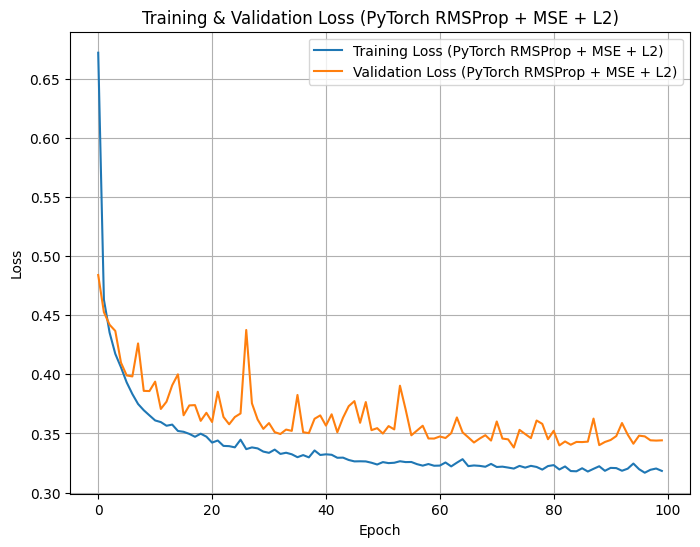

Loss curves for PyTorch RMSProp + MSE + L2 model plotted successfully.


In [15]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses_pytorch_mse_l2, label='Training Loss (PyTorch RMSProp + MSE + L2)')
plt.plot(val_losses_pytorch_mse_l2, label='Validation Loss (PyTorch RMSProp + MSE + L2)')
plt.title('Training & Validation Loss (PyTorch RMSProp + MSE + L2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
print("Loss curves for PyTorch RMSProp + MSE + L2 model plotted successfully.")

In [16]:
print("\n--- Reporting Losses for Pytorch Model ---")
final_val_loss_pytorch_mse_l2 = evaluate_model_loss(
    model_pytorch_mse_l2, val_loader, mse_loss_scratch, lambda_val_l2=lambda_l2, regularization_type='l2'
)
final_test_loss_mse_l2 = evaluate_model_loss(
    model_pytorch_mse_l2, test_loader, mse_loss_scratch, lambda_val_l2=lambda_l2, regularization_type='l2'
)
print(f"Pytorch Model (MSE + L2) - Final Validation Loss: {final_val_loss_pytorch_mse_l2:.4f}, Test Loss: {final_test_loss_mse_l2:.4f}")


--- Reporting Losses for Pytorch Model ---
Pytorch Model (MSE + L2) - Final Validation Loss: 0.3442, Test Loss: 0.3128


In [17]:
print('\033[1m' + 'Comparing results' + '\033[0m')
print(f"Custom Model (MSE + L2) - Final Validation Loss: {final_val_loss_mse_l2:.4f}, Test Loss: {final_test_loss_mse_l2:.4f}")
print(f"Pytorch Model (MSE + L2) - Final Validation Loss: {final_val_loss_pytorch_mse_l2:.4f}, Test Loss: {final_test_loss_mse_l2:.4f}")

Comparing results
Custom Model (MSE + L2) - Final Validation Loss: 0.3547, Test Loss: 0.3128
Pytorch Model (MSE + L2) - Final Validation Loss: 0.3442, Test Loss: 0.3128



## Question 6 (2 marks)
1. How can the performance of a regression model be evaluated in terms of how well it explains the variability present in the target variable?
2. When comparing two regression models where one model includes a larger number of input features, which evaluation metric should be preferred to fairly assess model performance? Explain why this metric is more appropriate in the presence of multiple features.


ANSWER TO #1 <br />
The performance of a regression model in explaining the variability present in the target variable is primarily evaluated using the **R-squared (R²)** score. R-squared measures the proportion of the variance in the dependent variable that can be predicted from the independent variables. It ranges from 0 to 1, where:
*   **R² = 1** indicates that the model explains all the variability of the target variable around its mean.
*   **R² = 0** indicates that the model explains none of the variability, performing no better than a simple mean of the target variable.
*   A higher R-squared value generally implies a better fit of the model to the data, as it indicates that a larger proportion of the variance in the target variable is accounted for by the model's predictors.

ANSWER TO #2 <br />
When comparing two regression models where one includes a larger number of input features, the **Adjusted R-squared (Adjusted R²)** should be preferred over the standard R-squared. This is because:
*   Standard R-squared will always increase or stay the same as more independent variables (features) are added to a model, even if those variables are not significant or do not improve the model's predictive power. This can lead to overfitting and falsely suggest that a more complex model is better.
*   Adjusted R-squared accounts for the number of predictors in the model. It penalizes the addition of unnecessary features by adjusting the R-squared value based on the number of predictors relative to the number of data points.
*  By penalizing complexity, Adjusted R-squared provides a more realistic and fair comparison between models with different numbers of features, especially when one model is more complex. A model with a higher Adjusted R-squared is generally considered better, as it indicates a better balance between model fit and model simplicity (i.e., it avoids overfitting by only including useful features).